In [1]:
import os

import torch

from src.agents import ContinuosActorCritic2
from src.networks import CriticNetwork, ActorNetwork
from src.pv_env import History, PVEnv
from src.reward import RewardDeltaPower

PV_PARAMS_PATH = os.path.join("parameters", "01_pvarray.json")
WEATHER_TRAIN_PATH = os.path.join("data", "weather_sim.csv")
WEATHER_TEST_PATH = os.path.join("data", "weather_real.csv")
PVARRAY_CKP_PATH = os.path.join('data', '01_pvarray_iv.json')
AGENT_CKP_PATH = os.path.join("models", "02_mppt_ac.tar")
LEARNING_RATE = 0.001
ENTROPY_BETA = 0.001
GAMMA = 0.9
N_STEPS = 4
BATCH_SIZE = 128

In [2]:
env = PVEnv.from_file(
    PV_PARAMS_PATH,
    WEATHER_TRAIN_PATH,
    pvarray_ckp_path=PVARRAY_CKP_PATH,
    states=["v_norm", "i_norm", "deg"],
    reward_fn=RewardDeltaPower(1, 0.9),
)
test_env = PVEnv.from_file(
    PV_PARAMS_PATH,
    WEATHER_TRAIN_PATH,
    pvarray_ckp_path=PVARRAY_CKP_PATH,
    states=["v_norm", "i_norm", "deg"],
    reward_fn=RewardDeltaPower(1, 0.9),
)
device = torch.device("cpu")
net = ActorNetwork(
    input_size=env.observation_space.shape[0],
    n_actions=env.action_space.shape[0]
).to(device)
value_net = CriticNetwork(
    input_size=env.observation_space.shape[0],
).to(device)
agent = ContinuosActorCritic2(
    env=env,
    test_env=test_env,
    net=net,
    device=device,
    gamma=GAMMA,
    beta_entropy=ENTROPY_BETA,
    lr=LEARNING_RATE,
    n_steps=N_STEPS,
    batch_size=BATCH_SIZE,
    # chk_path=AGENT_CKP_PATH,
    chk_path=None,
    value_net=value_net,
)

INFO 2020-11-18 12:15:46,200 Dictionary readed from parameters\01_pvarray.json
INFO 2020-11-18 12:15:46,202 Starting MATLAB engine . . .
INFO 2020-11-18 12:15:51,698 MATLAB engine initializated.
INFO 2020-11-18 12:16:11,682 Model loaded succesfully.
INFO 2020-11-18 12:16:11,716 Dictionary readed from data\01_pvarray_iv.json
INFO 2020-11-18 12:16:11,719 Reading data\weather_sim.csv . . .
INFO 2020-11-18 12:16:11,733 Dictionary readed from parameters\01_pvarray.json
INFO 2020-11-18 12:16:11,735 Starting MATLAB engine . . .
INFO 2020-11-18 12:16:17,141 MATLAB engine initializated.
INFO 2020-11-18 12:16:37,182 Model loaded succesfully.
INFO 2020-11-18 12:16:37,209 Dictionary readed from data\01_pvarray_iv.json
INFO 2020-11-18 12:16:37,211 Reading data\weather_sim.csv . . .


In [3]:
agent.learn(steps=1000, verbose_every=10, save_every=0)

  1%|          | 10/1000 [00:06<09:33,  1.73it/s]
 10: loss=-0.078849,  mean reward=-128.97,  steps/ep=833,  episodes=6
  2%|▏         | 20/1000 [00:11<08:01,  2.03it/s]
 20: loss=-0.011528,  mean reward=-184.33,  steps/ep=833,  episodes=12
  3%|▎         | 30/1000 [00:16<07:53,  2.05it/s]
 30: loss=0.013684,  mean reward=-188.52,  steps/ep=833,  episodes=18
  4%|▍         | 40/1000 [00:21<07:49,  2.04it/s]
 40: loss=0.047976,  mean reward=-220.47,  steps/ep=833,  episodes=24
  5%|▌         | 50/1000 [00:26<07:48,  2.03it/s]
 50: loss=0.000511,  mean reward=-228.27,  steps/ep=833,  episodes=30
  6%|▌         | 60/1000 [00:31<07:41,  2.04it/s]
 60: loss=-0.004941,  mean reward=-234.73,  steps/ep=833,  episodes=36
  7%|▋         | 70/1000 [00:36<07:37,  2.03it/s]
 70: loss=0.054697,  mean reward=-260.94,  steps/ep=833,  episodes=42
  8%|▊         | 80/1000 [00:40<07:28,  2.05it/s]
 80: loss=0.015092,  mean reward=-270.90,  steps/ep=833,  episodes=48
  9%|▉         | 90/1000 [00:45<07:30,

INFO 2020-11-18 12:24:54,254 Calculating true MPP . . .
Calculating true MPP: 100%|##########| 834/834 [00:01<00:00, 811.23it/s]
INFO 2020-11-18 12:24:55,285 Running P&O, step=0.2 volts . . .
Calculating PO: 100%|##########| 834/834 [00:00<00:00, 278307.70it/s]


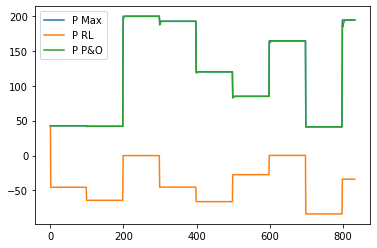

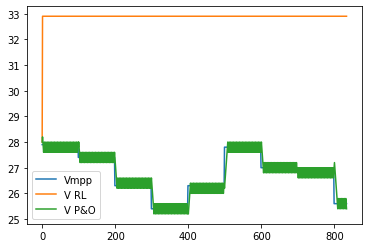

INFO 2020-11-18 12:24:55,888 PO Efficiency=99.87892064901877
INFO 2020-11-18 12:24:55,889 RL Efficiency=-69.18869946354322


In [4]:
agent.exp_train_source.play_episode()
env.render_vs_true(po=True)

INFO 2020-11-18 12:24:56,819 Calculating true MPP . . .
Calculating true MPP: 100%|##########| 834/834 [00:01<00:00, 818.39it/s]
INFO 2020-11-18 12:24:57,841 Running P&O, step=0.2 volts . . .
Calculating PO: 100%|##########| 834/834 [00:00<00:00, 207230.42it/s]


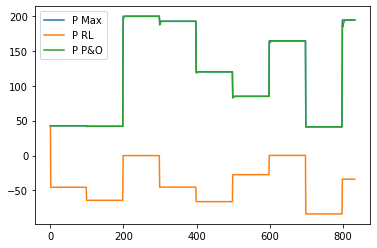

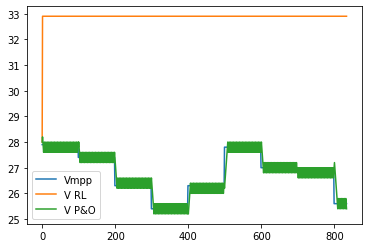

INFO 2020-11-18 12:24:58,400 PO Efficiency=99.87892064901877
INFO 2020-11-18 12:24:58,401 RL Efficiency=-69.18869946354322


In [5]:
agent.exp_test_source.play_episode()
test_env.render_vs_true(po=True)

In [6]:
obs = env.reset()
agent.policy(obs), agent.test_policy(obs), agent.net(torch.tensor(obs, dtype=torch.float32))

(112.487274,
 112.481964,
 (tensor([112.4820], grad_fn=<AddBackward0>),
  tensor([0.0004], grad_fn=<SoftplusBackward>),
  1))

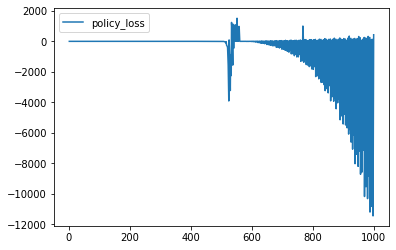

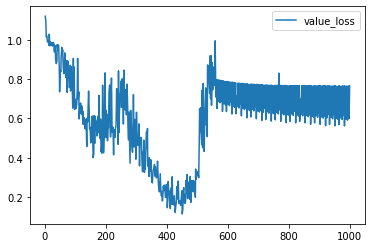

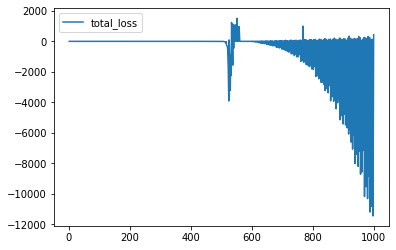

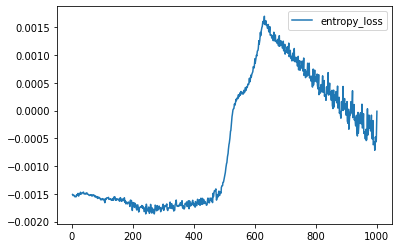

In [7]:
agent.plot_performance(['policy_loss', 'value_loss', 'total_loss', 'entropy_loss'])